In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd


from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression as logreg

import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma

from sklearn.feature_selection import chi2

import scipy as sp
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import pylab as pl
%pylab inline

import geopandas as gp

Populating the interactive namespace from numpy and matplotlib


In [2]:
def filterPerfectCorrelation(df):
    cols = df.columns
    removeCols = []
    for i in range(len(cols)-1):
        for j in range(i+1,len(cols)):
            cor = stats.pearsonr(df[cols[i]].values, df[cols[j]].values)[0]
            if cor >=1 or cor <=-1:
                removeCols.append(cols[i])
    return df[[c for c in cols if c not in removeCols]]
        

In [3]:
def bolleanToNumeric(df):
    for c in df.columns:
        df[c] = df[c].astype(int)
    return df

In [4]:
# remove class imballance by sampling from majority class
def classImballanceDownSample(df,ycol):
    df = df.copy()
    valueCount = df[ycol].value_counts()
    print("Before Class Imballance Treatment: ")
    print(valueCount)
    classes = valueCount.index
    counts = valueCount.values
    minClassSize = np.min(counts)
    for clas in classes:
        df1 = df[df[ycol]==clas]
        df2 = df[df[ycol]!=clas]
        
        df1 = df1.sample(n=minClassSize, random_state=50)
        df = df1.append(df2)
    #shuffling the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    print("After Class Imballance Treatment: ")
    print(df[ycol].value_counts())
    return df  

In [5]:
# remove class imballance by up sampling minority classes
def classImballanceUpSample(df,ycol):
    df = df.copy()
    valueCount = df[ycol].value_counts()
    print("Before Class Imballance Treatment: ")
    print(valueCount)
    classes = valueCount.index
    counts = valueCount.values
    maxClassSize = np.max(counts).astype(float)
    fractions = maxClassSize / counts
    for clas,f in zip(classes,fractions):
        df1 = df[df[ycol]==clas]
        df2 = df[df[ycol]!=clas]
        
        df1 = df1.sample(frac=f, replace=True, random_state=50)
        df = df1.append(df2)
    #shuffling the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    print("After Class Imballance Treatment: ")
    print(df[ycol].value_counts())
    return df  

In [6]:
# model that trains a default random forest and prints the report
def getModel(df,label, ballanceClasses=None, rfcBalance = None):
    
    xcols = [c for c in df.columns if c != label]
    ycols = [label]
    print("Predictors: ",len(xcols))
    print("label: ",ycols[0])
    
#     if ballanceClasses != None:
#         df = ballanceClasses(df, ycols[0])
        
    X = df[xcols]
    Y = df[ycols]
    
    #X = labelEncodeCategoricalFeatures(X)
    #print("Label Encoding.")
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
    print("Train Test Split:")
    print(np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape)
    
    if ballanceClasses != None:
        dfTrain = X_train
        dfTrain['label'] = y_train
        dfTrain = ballanceClasses(dfTrain,'label')
        X_train = dfTrain[ [c for c in dfTrain.columns if c not in 'label'] ]
        y_train = dfTrain['label']
    
    #print("Checking if sampling worked:")
    #print(y_train.value_counts())
    #print()
    
    if rfcBalance == None:
        clf = rfc()
    else:
        clf = rfc(class_weight = rfcBalance)
        print(clf)
    
    #clf = rfc()
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    print("Accuracy : ", np.sum(y_test[ycols[0]].values==y_pred).astype(float)/len(y_test) )
    print(classification_report(y_test[ycols[0]].values, y_pred))
    
    
    for th in [0.05,0.1,0.2,0.4,0.5,0.6,0.8]:
        y_pred = clf.predict_proba(X_test)[:,1] > th
        print('TH: ',th)
        print("Accuracy : ", np.sum(y_test[ycols[0]].values==y_pred).astype(float)/len(y_test) )
        print(classification_report(y_test[ycols[0]].values, y_pred))
        print()
    

In [7]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
def labelEncodeCategoricalFeatures(DF):
    df = DF.copy()
    for c in df.columns:
        if df[c].dtype.name == 'object':
            df[c] = labelencoder.fit_transform(df[c])
    return df

### Load Data

In [29]:
cleandf = pd.read_csv('cleanDataSmoke.csv')
cleandf.shape

(427526, 30)

In [30]:
cleandf.head()

,ads18_frequentHealthIssue,ads18_highBP,ads18_highChl,ads18_unknownChl,ads18_asthma,ads18_formerasthma,ads18_white,ads18_weight,ads18_obese,ads18_havechild,...,ads18_healthCov,ads18_older40,ads18_age18_25,ads18_age25_30,ads18_seatbelt,ads18_veteran,ads18_affordDoc,ads18_stroke,ads18_state,label
0,False,True,True,False,False,False,True,7348.0,True,False,...,True,True,False,False,True,True,True,False,Alabama,No
1,False,True,False,False,False,False,True,9571.0,True,False,...,True,True,False,False,True,False,True,False,Alabama,No
2,False,False,True,False,False,False,True,8845.0,True,False,...,True,True,False,False,True,False,True,False,Alabama,No
3,False,True,True,False,False,False,True,7711.0,True,False,...,True,True,False,False,False,False,True,False,Alabama,No
4,True,False,False,False,True,False,True,6350.0,False,False,...,True,True,False,False,False,False,True,False,Alabama,No


In [31]:
print("Records: ",len(cleandf))
cleandf = cleandf.dropna()
print("Records after cleaning Nan: ",len(cleandf))

Records:  427526
Records after cleaning Nan:  384321


In [32]:
cleandf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384321 entries, 0 to 427525
Data columns (total 30 columns):
ads18_frequentHealthIssue    384321 non-null bool
ads18_highBP                 384321 non-null bool
ads18_highChl                384321 non-null bool
ads18_unknownChl             384321 non-null bool
ads18_asthma                 384321 non-null bool
ads18_formerasthma           384321 non-null bool
ads18_white                  384321 non-null bool
ads18_weight                 384321 non-null float64
ads18_obese                  384321 non-null bool
ads18_havechild              384321 non-null bool
ads18_edu                    384321 non-null int64
ads18_income                 384321 non-null int64
ads18_drinkdaily             384321 non-null bool
ads18_drinkbinge             384321 non-null bool
ads18_fruitIntake            384321 non-null float64
ads18_vegIntake              384321 non-null float64
ads18_potatoIntake           384321 non-null float64
ads18_exercise           

In [33]:
cleandf['label'] = cleandf.label == 'Yes'
cleandf.label.value_counts()

False    327634
True      56687
Name: label, dtype: int64

In [34]:
#Pick the Cigeratte tax rate in 2017
tax = pd.read_csv('Tax.csv')
tax17 = tax[tax['Year']==2017]
tax17.head()
tax_value = tax17[tax17['ProvisionDesc'] == 'Cigarette Tax ($ per pack)'].sort_values('LocationDesc')
tax_value = tax_value.groupby('LocationDesc').max()
tax_value = tax_value[['ProvisionAltValue']]
tax_value.rename(columns={'ProvisionAltValue':'Cigarette_tax'}, inplace=True)
tax_value.reset_index(inplace=True)
print(tax_value.shape)
tax_value.head()

(58, 2)


,LocationDesc,Cigarette_tax
0,Alabama,0.675
1,Alaska,2.000
2,American Samoa,6.000
3,Arizona,2.000
4,Arkansas,1.150


In [35]:
cleandf = cleandf.merge(tax_value, left_on='ads18_state', right_on='LocationDesc', how='left')
cleandf.drop(columns = ['LocationDesc'] , inplace=True )

In [36]:
cleandf.shape

(384321, 31)

In [37]:
mormondf = pd.read_csv('mormon.csv',skiprows=1)
mormondf.columns = ['MState','mormon']
print(mormondf.shape)
mormondf.head()

(51, 2)


,MState,mormon
0,Utah,100
1,Idaho,40
2,Wyoming,22
3,Arizona,15
4,Alaska,13


In [38]:
cleandf = cleandf.merge(mormondf, left_on='ads18_state', right_on='MState', how='left')
cleandf.drop(columns = ['MState'] , inplace=True )

In [40]:
cleandf['mormon'].fillna(np.mean(cleandf['mormon']), inplace=True)

## Model with out imballance treatment

In [41]:
Y= cleandf['label']
X = cleandf[[c for c in cleandf.columns if c not in ['label','ads18_state']]]
print("columns :", len(X.columns))
X = filterPerfectCorrelation(X)
X = bolleanToNumeric(X)
print("Uncorrelated columns :", len(X.columns))

logit_mod = sma.Logit(Y, X, method='bfgs').fit()
print(logit_mod.summary())

columns : 30
Uncorrelated columns : 30
Optimization terminated successfully.
         Current function value: 0.369675
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               384321
Model:                          Logit   Df Residuals:                   384291
Method:                           MLE   Df Model:                           29
Date:                Wed, 12 Dec 2018   Pseudo R-squ.:                  0.1163
Time:                        00:29:21   Log-Likelihood:            -1.4207e+05
converged:                       True   LL-Null:                   -1.6078e+05
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ads18_frequentHealthIssue     0.4807   

In [42]:
result = pd.concat([logit_mod.params, logit_mod.pvalues], axis=1).reset_index() 
result.columns = ['var','coef','pval']
result

,var,coef,pval
0,ads18_frequentHealthIssue,0.480686,3.201517e-298
1,ads18_highBP,-0.074574,3.514977e-11
2,ads18_highChl,0.030154,8.389179e-03
3,ads18_unknownChl,0.390340,8.565535e-152
4,ads18_asthma,0.234959,1.682901e-53
5,ads18_formerasthma,-0.171250,2.405419e-10
6,ads18_white,0.309325,1.014836e-146
7,ads18_weight,0.000038,2.090275e-48
8,ads18_obese,-0.363368,1.963374e-175
9,ads18_havechild,0.243777,2.505283e-101


AUC:  0.742117601537


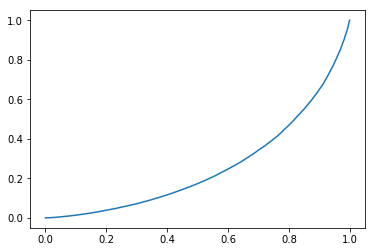

In [43]:
pred = logit_mod.predict() #> 0.5
fpr, tpr, thresholds = metrics.roc_curve(Y, pred)
print('AUC: ',metrics.auc(fpr, tpr))
pl.plot(tpr,fpr)

In [44]:
for th in [0.05,0.1,0.2,0.4,0.5,0.6,0.8]:
        print('TH: ',th)
        print("Accuracy : ", np.sum(Y==(pred > th)).astype(float)/len(Y) )
        print(classification_report(Y, pred > th))
        print()


TH:  0.05
Accuracy :  0.261632853786
              precision    recall  f1-score   support

       False       0.97      0.14      0.24    327634
        True       0.16      0.97      0.28     56687

   micro avg       0.26      0.26      0.26    384321
   macro avg       0.56      0.56      0.26    384321
weighted avg       0.85      0.26      0.25    384321


TH:  0.1
Accuracy :  0.541612350093
              precision    recall  f1-score   support

       False       0.94      0.49      0.65    327634
        True       0.22      0.82      0.35     56687

   micro avg       0.54      0.54      0.54    384321
   macro avg       0.58      0.66      0.50    384321
weighted avg       0.84      0.54      0.60    384321


TH:  0.2
Accuracy :  0.78148995241
              precision    recall  f1-score   support

       False       0.90      0.83      0.87    327634
        True       0.34      0.49      0.40     56687

   micro avg       0.78      0.78      0.78    384321
   macro avg      

## DownSample

In [45]:
cleandfDn = classImballanceDownSample(cleandf, 'label')

Before Class Imballance Treatment: 
False    327634
True      56687
Name: label, dtype: int64
After Class Imballance Treatment: 
True     56687
False    56687
Name: label, dtype: int64


In [46]:
Y= cleandfDn['label']
X = cleandfDn[[c for c in cleandfDn.columns if c not in ['label','ads18_state'] ]]
print("columns :", len(X.columns))
X = filterPerfectCorrelation(X)
X = bolleanToNumeric(X)
print("Uncorrelated columns :", len(X.columns))

logit_mod = sma.Logit(Y, X, method='bfgs').fit()
print(logit_mod.summary())

columns : 30
Uncorrelated columns : 30
Optimization terminated successfully.
         Current function value: 0.618785
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               113374
Model:                          Logit   Df Residuals:                   113344
Method:                           MLE   Df Model:                           29
Date:                Wed, 12 Dec 2018   Pseudo R-squ.:                  0.1073
Time:                        00:30:33   Log-Likelihood:                -70154.
converged:                       True   LL-Null:                       -78585.
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ads18_frequentHealthIssue     0.5575   

In [47]:
resultds = pd.concat([logit_mod.params, logit_mod.pvalues], axis=1).reset_index() 
resultds.columns = ['var','coef','pval']
resultds

,var,coef,pval
0,ads18_frequentHealthIssue,0.557530,2.767805e-202
1,ads18_highBP,-0.072054,1.025303e-06
2,ads18_highChl,0.049237,1.066492e-03
3,ads18_unknownChl,0.502562,1.674114e-128
4,ads18_asthma,0.225625,1.741675e-26
5,ads18_formerasthma,-0.145723,8.029341e-05
6,ads18_white,0.277778,2.024602e-71
7,ads18_weight,0.000126,3.062898e-252
8,ads18_obese,-0.453754,9.282686e-153
9,ads18_havechild,0.339947,3.992321e-107


AUC:  0.720020154509


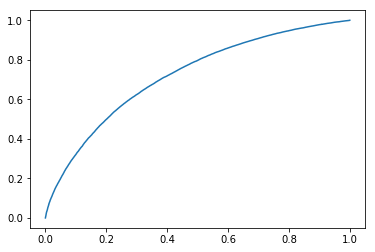

In [48]:
pred = logit_mod.predict() #> 0.5
fpr, tpr, thresholds = metrics.roc_curve(Y, pred)
print('AUC: ',metrics.auc(fpr, tpr))
pl.plot(fpr,tpr)

In [49]:
for th in [0.05,0.1,0.2,0.4,0.5,0.6,0.8]:
        print('TH: ',th)
        print("Accuracy : ", np.sum(Y==(pred > th)).astype(float)/len(Y) )
        print(classification_report(Y, pred > th))
        print()


TH:  0.05
Accuracy :  0.500167586925
              precision    recall  f1-score   support

       False       0.61      0.00      0.00     56687
        True       0.50      1.00      0.67     56687

   micro avg       0.50      0.50      0.50    113374
   macro avg       0.55      0.50      0.33    113374
weighted avg       0.55      0.50      0.33    113374


TH:  0.1
Accuracy :  0.50057332369
              precision    recall  f1-score   support

       False       0.68      0.00      0.00     56687
        True       0.50      1.00      0.67     56687

   micro avg       0.50      0.50      0.50    113374
   macro avg       0.59      0.50      0.34    113374
weighted avg       0.59      0.50      0.34    113374


TH:  0.2
Accuracy :  0.525631979113
              precision    recall  f1-score   support

       False       0.82      0.07      0.12     56687
        True       0.51      0.99      0.68     56687

   micro avg       0.53      0.53      0.53    113374
   macro avg      

### Residual Analysis

(array([   804.,  11438.,  20534.,  18344.,   5563.,   3711.,  25704.,
         18615.,   7639.,   1022.]),
 array([ -9.99999892e-01,  -8.00004215e-01,  -6.00008537e-01,
         -4.00012860e-01,  -2.00017183e-01,  -2.15063676e-05,
          1.99974171e-01,   3.99969848e-01,   5.99965525e-01,
          7.99961202e-01,   9.99956879e-01]),
 <a list of 10 Patch objects>)

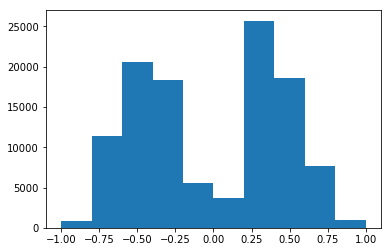

In [50]:
Yint = Y.astype(int)
error = pred - Yint
pl.hist(error)

In [51]:
fp = (~Y) & (pred>0.5)
fn = (Y) & (pred<=0.5)
tptn = Y ==  (pred<=0.5)

In [52]:
errordf = pd.DataFrame({'error':error, 'state':cleandfDn.ads18_state, 'fp':fp, 'fn':fn, 'tptn':tptn, 'pred':pred, 'truth':Y})

In [53]:
statesshp =  gp.GeoDataFrame.from_file('stateshp/cb_2017_us_state_5m.shp')
statesshp = statesshp.to_crs(epsg = 4326)

In [54]:
zip(sorted(statesshp.NAME),sorted(set(errordf.state)))

[(u'Alabama', 'Alabama'),
 (u'Alaska', 'Alaska'),
 (u'American Samoa', 'Arizona'),
 (u'Arizona', 'Arkansas'),
 (u'Arkansas', 'California'),
 (u'California', 'Colorado'),
 (u'Colorado', 'Connecticut'),
 (u'Commonwealth of the Northern Mariana Islands', 'Delaware'),
 (u'Connecticut', 'District of Columbia'),
 (u'Delaware', 'Florida'),
 (u'District of Columbia', 'Georgia'),
 (u'Florida', 'Guam'),
 (u'Georgia', 'Hawaii'),
 (u'Guam', 'Idaho'),
 (u'Hawaii', 'Illinois'),
 (u'Idaho', 'Indiana'),
 (u'Illinois', 'Iowa'),
 (u'Indiana', 'Kansas'),
 (u'Iowa', 'Kentucky'),
 (u'Kansas', 'Louisiana'),
 (u'Kentucky', 'Maine'),
 (u'Louisiana', 'Maryland'),
 (u'Maine', 'Massachusetts'),
 (u'Maryland', 'Michigan'),
 (u'Massachusetts', 'Minnesota'),
 (u'Michigan', 'Mississippi'),
 (u'Minnesota', 'Missouri'),
 (u'Mississippi', 'Montana'),
 (u'Missouri', 'Nebraska'),
 (u'Montana', 'Nevada'),
 (u'Nebraska', 'New Hampshire'),
 (u'Nevada', 'New Jersey'),
 (u'New Hampshire', 'New Mexico'),
 (u'New Jersey', 'New 

In [55]:
errordf = errordf.groupby('state').mean().reset_index()
errordf.shape

(53, 7)

(array([  1.,   1.,   3.,   9.,  17.,  12.,   9.,   0.,   0.,   1.]),
 array([-0.14970594, -0.12149744, -0.09328893, -0.06508043, -0.03687192,
        -0.00866342,  0.01954509,  0.0477536 ,  0.0759621 ,  0.10417061,
         0.13237911]),
 <a list of 10 Patch objects>)

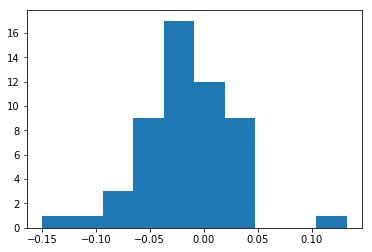

In [56]:
pl.hist(errordf.error)

In [57]:
statesshp.shape

(56, 10)

In [58]:
statesshp = statesshp.merge(errordf, left_on='NAME', right_on='state', how='left')

In [59]:
statesshp.shape

(56, 17)

/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


(25, 50)

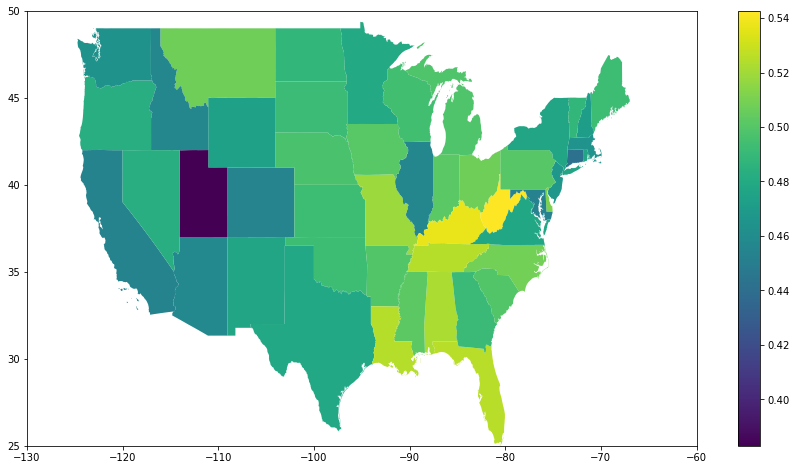

In [60]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='pred',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

(25, 50)

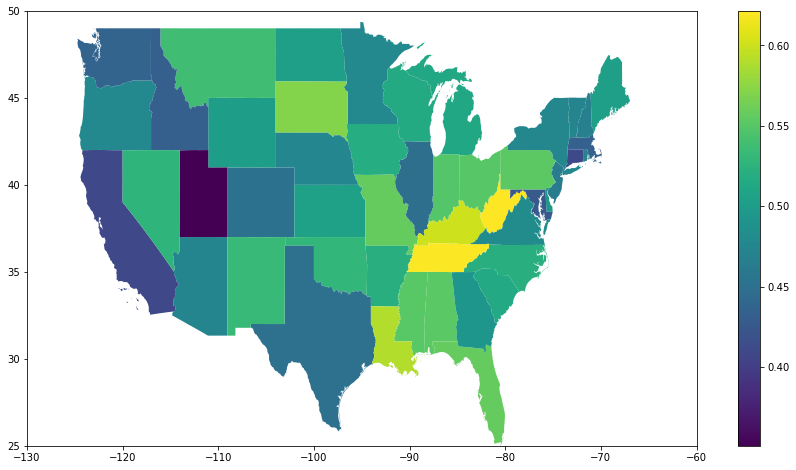

In [61]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='truth',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

(25, 50)

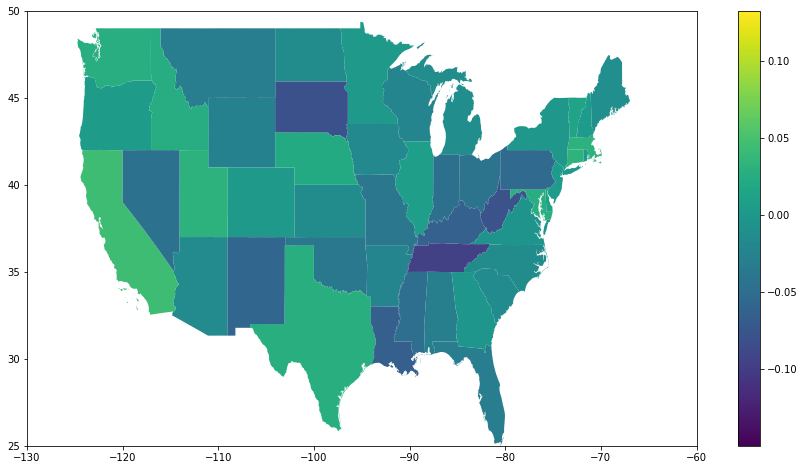

In [62]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='error',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [65]:
mormondf = pd.read_csv('mormon.csv',skiprows=1)
mormondf.columns = ['State','mormon']
print(mormondf.shape)
mormondf.head()

(51, 2)


,State,mormon
0,Utah,100
1,Idaho,40
2,Wyoming,22
3,Arizona,15
4,Alaska,13


In [66]:
statesshp = statesshp.merge(mormondf, left_on='NAME', right_on='State', how='left')

In [ ]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='Cigarette_tax',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

(25, 50)

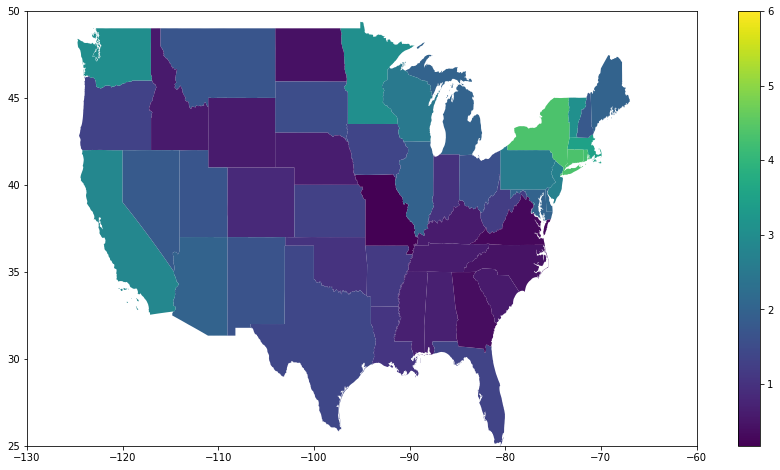

In [65]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='Cigarette_tax',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [66]:
statesshp.corr()

,ALAND,AWATER,error,fn,fp,pred,tptn,truth,Cigarette_tax
ALAND,1.000000,0.787169,0.104371,0.098994,-0.088067,0.029249,0.022225,0.092570,-0.184513
AWATER,0.787169,1.000000,0.154298,0.123423,-0.088734,0.075641,0.052131,0.149335,0.030676
error,0.104371,0.154298,1.000000,0.803114,-0.663444,0.407826,0.239459,0.936090,-0.359207
fn,0.098994,0.123423,0.803114,1.000000,-0.659760,-0.075149,0.490985,0.596652,-0.032035
fp,-0.088067,-0.088734,-0.663444,-0.659760,1.000000,0.269533,0.330730,-0.412965,0.246990
pred,0.029249,0.075641,0.407826,-0.075149,0.269533,1.000000,0.218088,0.702941,-0.436296
tptn,0.022225,0.052131,0.239459,0.490985,0.330730,0.218088,1.000000,0.270552,0.246099
truth,0.092570,0.149335,0.936090,0.596652,-0.412965,0.702941,0.270552,1.000000,-0.447898
Cigarette_tax,-0.184513,0.030676,-0.359207,-0.032035,0.246990,-0.436296,0.246099,-0.447898,1.000000


(25, 50)

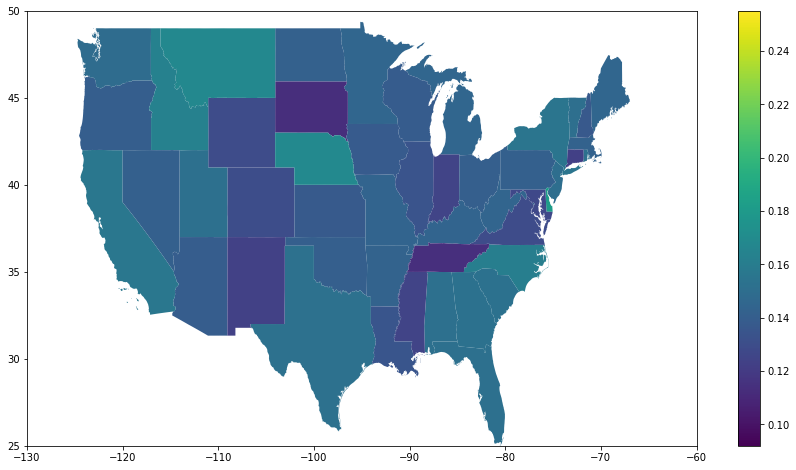

In [49]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='fp',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

(25, 50)

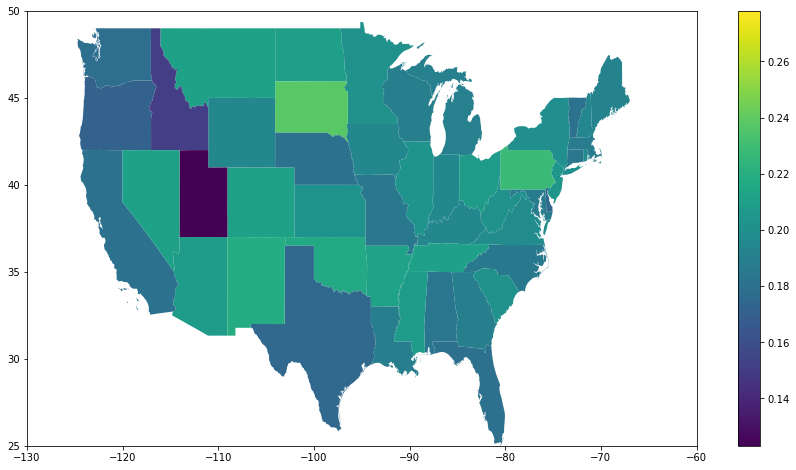

In [50]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='fn',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

(25, 50)

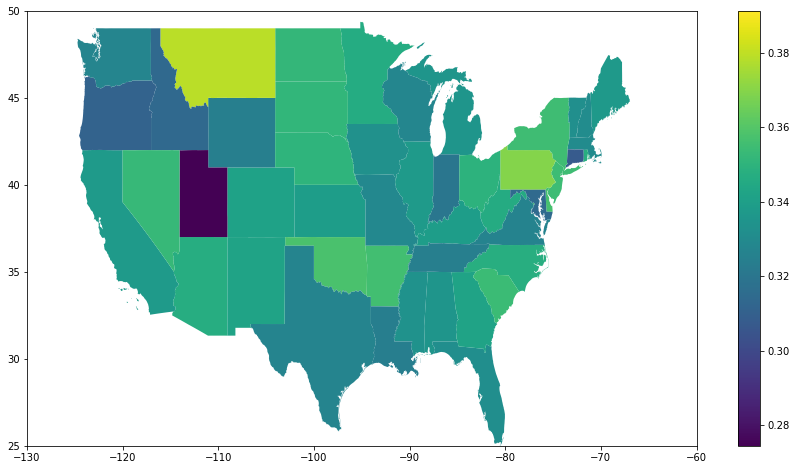

In [51]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='tptn',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [50]:
statesshp.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131174431216,4592944701,"(POLYGON ((-88.04374299999999 30.517423, -88.0..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-150.242099 61.137835, -150.228774 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
3,08,01779779,0400000US08,08,CO,Colorado,00,268425964573,1178495763,"POLYGON ((-109.060253 38.599328, -109.059541 3..."
4,12,00294478,0400000US12,12,FL,Florida,00,138911437206,31398800291,"(POLYGON ((-80.751643 24.857254, -80.729063 24..."


In [55]:
statesshp['NAME']

0                                          Alabama
1                                           Alaska
2                                          Arizona
3                                         Colorado
4                                          Florida
5                                          Georgia
6                                          Indiana
7                                           Kansas
8                                            Maine
9                                    Massachusetts
10                                       Minnesota
11                                      New Jersey
12                                  North Carolina
13                                    North Dakota
14                                        Oklahoma
15                                    Pennsylvania
16                                    South Dakota
17                                           Texas
18                                         Wyoming
19                             

## Upsample

In [43]:
cleandf = classImballanceUpSample(cleandf, 'label')

Before Class Imballance Treatment: 
False    50092
True      5861
Name: label, dtype: int64
After Class Imballance Treatment: 
True     50092
False    50092
Name: label, dtype: int64


In [44]:
Y= cleandf['label']
X = cleandf[[c for c in cleandf.columns if c != 'label']]
print("columns :", len(X.columns))
X = filterPerfectCorrelation(X)
X = bolleanToNumeric(X)
print("Uncorrelated columns :", len(X.columns))

logit_mod = sma.Logit(Y, X, method='bfgs').fit()
print(logit_mod.summary())

columns : 28
Uncorrelated columns : 28
Optimization terminated successfully.
         Current function value: 0.608194
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               100184
Model:                          Logit   Df Residuals:                   100156
Method:                           MLE   Df Model:                           27
Date:                Sat, 08 Dec 2018   Pseudo R-squ.:                  0.1226
Time:                        23:13:00   Log-Likelihood:                -60931.
converged:                       True   LL-Null:                       -69442.
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ads18_frequentHealthIssue     0.0477   

In [49]:
resultus = pd.concat([logit_mod.params, logit_mod.pvalues], axis=1).reset_index() 
resultus.columns = ['var','coef','pval']
resultus

,var,coef,pval
0,ads18_frequentHealthIssue,0.047707,1.179030e-02
1,ads18_highBP,-0.127535,3.833977e-15
2,ads18_highChl,0.093642,3.787030e-08
3,ads18_unknownChl,-0.125848,1.592740e-10
4,ads18_asthma,-0.123284,3.488779e-08
5,ads18_formerasthma,0.346895,3.641349e-21
6,ads18_white,0.134320,9.825148e-17
7,ads18_weight,-0.000052,7.918663e-43
8,ads18_obese,0.333942,1.531735e-72
9,ads18_havechild,-0.190321,8.514264e-34


AUC:  0.7226427590673072


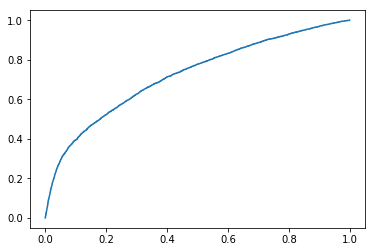

In [47]:
pred = logit_mod.predict() #> 0.5
fpr, tpr, thresholds = metrics.roc_curve(Y, pred)
print('AUC: ',metrics.auc(fpr, tpr))
pl.plot(fpr,tpr)

In [48]:
print(classification_report(Y,pred>0.5))

              precision    recall  f1-score   support

       False       0.64      0.74      0.69     50092
        True       0.69      0.59      0.63     50092

   micro avg       0.66      0.66      0.66    100184
   macro avg       0.67      0.66      0.66    100184
weighted avg       0.67      0.66      0.66    100184



## compare coeffs

In [62]:
resultAll = result.merge(resultds,left_on=['var'], right_on=['var'], how='inner')
resultAll = resultAll.merge(resultus,left_on=['var'], right_on=['var'], how='inner')
resultAll

,var,coef_x,pval_x,coef_y,pval_y,coef,pval
0,ads18_frequentHealthIssue,-0.108867,8.842534e-03,0.023642,6.704386e-01,0.047707,1.179030e-02
1,ads18_highBP,-0.139858,7.065108e-05,-0.180682,1.300412e-04,-0.127535,3.833977e-15
2,ads18_highChl,0.062105,9.735393e-02,0.127884,1.039622e-02,0.093642,3.787030e-08
3,ads18_unknownChl,-0.242607,2.244453e-10,-0.101688,7.693387e-02,-0.125848,1.592740e-10
4,ads18_asthma,-0.151424,1.421701e-03,-0.067969,2.977583e-01,-0.123284,3.488779e-08
5,ads18_formerasthma,0.282826,1.097476e-04,0.276432,9.776993e-03,0.346895,3.641349e-21
6,ads18_white,-0.005228,8.713164e-01,0.149586,1.544584e-03,0.134320,9.825148e-17
7,ads18_weight,-0.000180,2.952710e-97,-0.000050,8.019405e-06,-0.000052,7.918663e-43
8,ads18_obese,0.467667,5.908675e-35,0.354421,6.699575e-11,0.333942,1.531735e-72
9,ads18_havechild,-0.393709,2.271463e-33,-0.266815,5.803190e-09,-0.190321,8.514264e-34


In [63]:
resultAll[['var','coef_x','coef_y','coef']]

,var,coef_x,coef_y,coef
0,ads18_frequentHealthIssue,-0.108867,0.023642,0.047707
1,ads18_highBP,-0.139858,-0.180682,-0.127535
2,ads18_highChl,0.062105,0.127884,0.093642
3,ads18_unknownChl,-0.242607,-0.101688,-0.125848
4,ads18_asthma,-0.151424,-0.067969,-0.123284
5,ads18_formerasthma,0.282826,0.276432,0.346895
6,ads18_white,-0.005228,0.149586,0.134320
7,ads18_weight,-0.000180,-0.000050,-0.000052
8,ads18_obese,0.467667,0.354421,0.333942
9,ads18_havechild,-0.393709,-0.266815,-0.190321


### Random Forest Models

In [115]:
getModel(cleandf[[c for c in cleandf.columns if c != 'ads18_state']],'label', ballanceClasses=None, rfcBalance = None)

Predictors:  28
label:  label
Train Test Split:
(37488, 28) (18465, 28) (37488, 1) (18465, 1)
Accuracy :  0.896506904955
              precision    recall  f1-score   support

       False       0.90      0.99      0.94     16550
        True       0.51      0.10      0.17      1915

   micro avg       0.90      0.90      0.90     18465
   macro avg       0.71      0.55      0.56     18465
weighted avg       0.86      0.90      0.86     18465

TH:  0.05
Accuracy :  0.462442458706
              precision    recall  f1-score   support

       False       0.94      0.43      0.59     16550
        True       0.13      0.76      0.23      1915

   micro avg       0.46      0.46      0.46     18465
   macro avg       0.54      0.59      0.41     18465
weighted avg       0.86      0.46      0.55     18465


TH:  0.1
Accuracy :  0.714216084484
              precision    recall  f1-score   support

       False       0.93      0.74      0.82     16550
        True       0.19      0.53      0.2

In [100]:
getModel(labelEncodeCategoricalFeatures(cleandf),'label', ballanceClasses=None, rfcBalance = None)

Predictors:  29
label:  label
Train Test Split:
(37488, 29) (18465, 29) (37488, 1) (18465, 1)
Accuracy :  0.897373409152
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     16550
        True       0.53      0.10      0.17      1915

   micro avg       0.90      0.90      0.90     18465
   macro avg       0.72      0.55      0.56     18465
weighted avg       0.87      0.90      0.87     18465



In [101]:
getModel(cleandf[[c for c in cleandf.columns if c != 'ads18_state']],'label', ballanceClasses=classImballanceDownSample, rfcBalance = None)

Predictors:  28
label:  label
Train Test Split:
(37488, 28) (18465, 28) (37488, 1) (18465, 1)
Before Class Imballance Treatment: 
False    33542
True      3946
Name: label, dtype: int64
After Class Imballance Treatment: 
True     3946
False    3946
Name: label, dtype: int64
Accuracy :  0.704738694828
              precision    recall  f1-score   support

       False       0.93      0.72      0.81     16550
        True       0.19      0.55      0.28      1915

   micro avg       0.70      0.70      0.70     18465
   macro avg       0.56      0.64      0.55     18465
weighted avg       0.86      0.70      0.76     18465



/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [103]:
getModel(labelEncodeCategoricalFeatures(cleandf),'label', ballanceClasses=classImballanceDownSample, rfcBalance = None)

Predictors:  29
label:  label
Train Test Split:
(37488, 29) (18465, 29) (37488, 1) (18465, 1)
Before Class Imballance Treatment: 
False    33542
True      3946
Name: label, dtype: int64
After Class Imballance Treatment: 
True     3946
False    3946
Name: label, dtype: int64
Accuracy :  0.707988085567
              precision    recall  f1-score   support

       False       0.93      0.73      0.82     16550
        True       0.19      0.56      0.28      1915

   micro avg       0.71      0.71      0.71     18465
   macro avg       0.56      0.64      0.55     18465
weighted avg       0.86      0.71      0.76     18465



/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
getModel(cleandf[[c for c in cleandf.columns if c != 'ads18_state']],'label', ballanceClasses=classImballanceUpSample, rfcBalance = None)

Predictors:  28
label:  label
Train Test Split:
(37488, 28) (18465, 28) (37488, 1) (18465, 1)
Before Class Imballance Treatment: 
False    33542
True      3946
Name: label, dtype: int64
After Class Imballance Treatment: 
True     33542
False    33542
Name: label, dtype: int64


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Accuracy :  0.884917411319
              precision    recall  f1-score   support

       False       0.91      0.96      0.94     16550
        True       0.39      0.20      0.26      1915

   micro avg       0.88      0.88      0.88     18465
   macro avg       0.65      0.58      0.60     18465
weighted avg       0.86      0.88      0.87     18465



In [105]:
getModel(labelEncodeCategoricalFeatures(cleandf),'label', ballanceClasses=classImballanceUpSample, rfcBalance = None)

Predictors:  29
label:  label
Train Test Split:
(37488, 29) (18465, 29) (37488, 1) (18465, 1)
Before Class Imballance Treatment: 
False    33542
True      3946
Name: label, dtype: int64
After Class Imballance Treatment: 
True     33542
False    33542
Name: label, dtype: int64


/home/urwa/miniconda3/envs/gpd/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Accuracy :  0.888166802058
              precision    recall  f1-score   support

       False       0.91      0.97      0.94     16550
        True       0.42      0.20      0.27      1915

   micro avg       0.89      0.89      0.89     18465
   macro avg       0.66      0.58      0.60     18465
weighted avg       0.86      0.89      0.87     18465



##